In [56]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PseudoCode For loading and analysis

1. Load the pickled pandas dataframe 
2. Examine contents to assure everything transferred properly - **white spaces identified**
2a. Replace white spaces with nans
3. **Filter down to just questions (PostTypeId = '1')**
4. Convert objects to correct dtype - **Body, Title, and Tag to be converted later**
5. Check for missing values - none found in crucial columns
6. Check for duplicates - **a few found**
6a. Remove duplicates
7. Preprocess tags - remove html tags and convert to string
8. Get a list of all the Tags and Frequency Counts
9. Do some exploratory anal/viz on tags related to their frequency
10. Do some exploratory anal/viz on other features such as ViewCount and Score
11. Write out the filtered data frame with new features; next notebook will concentrate on cleaning and prepping body text

# Tasks 1 - 6
1. Load dataframe
2. Examine contents to assure everything transferred properly - white spaces identified 2a. Replace white spaces with nans
3. Filter down to just questions (PostTypeId = '1')
4. Convert objects to correct dtype - Body, Title, and Tag to be converted later
5. Check for missing values - none found in crucial columns
6. Check for duplicates - a few found 6a. Remove duplicates

In [57]:
'''
Import all modules that are needed
'''
import pandas as pd
import pickle
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
'''
1. Load the pickled pandas dataframe 
'''
posts_df = pd.read_pickle('/content/drive/My Drive/Capstone2/Data/posts_df_09112020.pickle')

posts_df.info()
'''
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51395 entries, 0 to 51394
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                51395 non-null  object
 1   PostTypeId        51395 non-null  object
 2   CreationDate      51395 non-null  object
 3   Score             51395 non-null  object
 4   ViewCount         51395 non-null  object
 5   Body              51395 non-null  object
 6   OwnerUserId       51395 non-null  object
 7   LastActivityDate  51395 non-null  object
 8   Title             51395 non-null  object
 9   Tags              51395 non-null  object
 10  AnswerCount       51395 non-null  object
 11  CommentCount      51395 non-null  object
 12  FavoriteCount     51395 non-null  object
 13  ClosedDate        51395 non-null  object
 14  ContentLicense    51395 non-null  object
dtypes: object(15)
memory usage: 5.9+ MB
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51395 entries, 0 to 51394
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                51395 non-null  object
 1   PostTypeId        51395 non-null  object
 2   CreationDate      51395 non-null  object
 3   Score             51395 non-null  object
 4   ViewCount         51395 non-null  object
 5   Body              51395 non-null  object
 6   OwnerUserId       51395 non-null  object
 7   LastActivityDate  51395 non-null  object
 8   Title             51395 non-null  object
 9   Tags              51395 non-null  object
 10  AnswerCount       51395 non-null  object
 11  CommentCount      51395 non-null  object
 12  FavoriteCount     51395 non-null  object
 13  ClosedDate        51395 non-null  object
 14  ContentLicense    51395 non-null  object
dtypes: object(15)
memory usage: 5.9+ MB


"\n<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 51395 entries, 0 to 51394\nData columns (total 15 columns):\n #   Column            Non-Null Count  Dtype \n---  ------            --------------  ----- \n 0   Id                51395 non-null  object\n 1   PostTypeId        51395 non-null  object\n 2   CreationDate      51395 non-null  object\n 3   Score             51395 non-null  object\n 4   ViewCount         51395 non-null  object\n 5   Body              51395 non-null  object\n 6   OwnerUserId       51395 non-null  object\n 7   LastActivityDate  51395 non-null  object\n 8   Title             51395 non-null  object\n 9   Tags              51395 non-null  object\n 10  AnswerCount       51395 non-null  object\n 11  CommentCount      51395 non-null  object\n 12  FavoriteCount     51395 non-null  object\n 13  ClosedDate        51395 non-null  object\n 14  ContentLicense    51395 non-null  object\ndtypes: object(15)\nmemory usage: 5.9+ MB\n"

In [59]:
'''
2. Examine contents
'''
posts_df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense
0,5,1,2014-05-13T23:58:30.457,9,708,<p>I've always been interested in machine lear...,5,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,1,1,1,2014-05-14T14:40:25.950,CC BY-SA 3.0
1,7,1,2014-05-14T00:11:06.457,4,441,"<p>As a researcher and instructor, I'm looking...",36,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,3,4,1,2014-05-14T08:40:54.950,CC BY-SA 3.0
2,9,2,2014-05-14T00:36:31.077,5,,"<p>Not sure if this fits the scope of this SE,...",51,2014-05-14T00:36:31.077,,,,0,,,CC BY-SA 3.0
3,10,2,2014-05-14T00:53:43.273,13,,"<p>One book that's freely available is ""The El...",22,2014-05-14T00:53:43.273,,,,1,,,CC BY-SA 3.0
4,14,1,2014-05-14T01:25:59.677,22,1717,<p>I am sure data science as will be discussed...,66,2014-06-20T17:36:05.023,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4,1,6,,CC BY-SA 3.0


In [60]:
'''
2a. Note that there are blanks in the data where white spaces have been left from the extraction script
These should be replaced with nans
'''
posts_df = posts_df.replace(r'^\s*$', np.nan, regex=True)
posts_df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense
0,5,1,2014-05-13T23:58:30.457,9,708,<p>I've always been interested in machine lear...,5,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,1,1,1,2014-05-14T14:40:25.950,CC BY-SA 3.0
1,7,1,2014-05-14T00:11:06.457,4,441,"<p>As a researcher and instructor, I'm looking...",36,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,3,4,1,2014-05-14T08:40:54.950,CC BY-SA 3.0
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51,2014-05-14T00:36:31.077,NaN,NaN,NaN,0,NaN,NaN,CC BY-SA 3.0
3,10,2,2014-05-14T00:53:43.273,13,NaN,"<p>One book that's freely available is ""The El...",22,2014-05-14T00:53:43.273,NaN,NaN,NaN,1,NaN,NaN,CC BY-SA 3.0
4,14,1,2014-05-14T01:25:59.677,22,1717,<p>I am sure data science as will be discussed...,66,2014-06-20T17:36:05.023,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4,1,6,NaN,CC BY-SA 3.0


In [61]:
'''
2b. Nulls now showing properly; also note dtype on all is object; this will be corrected after filtering just to questions
'''
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51395 entries, 0 to 51394
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                51395 non-null  object
 1   PostTypeId        51395 non-null  object
 2   CreationDate      51395 non-null  object
 3   Score             51395 non-null  object
 4   ViewCount         24363 non-null  object
 5   Body              51254 non-null  object
 6   OwnerUserId       51153 non-null  object
 7   LastActivityDate  51395 non-null  object
 8   Title             24363 non-null  object
 9   Tags              24363 non-null  object
 10  AnswerCount       24363 non-null  object
 11  CommentCount      51395 non-null  object
 12  FavoriteCount     6710 non-null   object
 13  ClosedDate        1422 non-null   object
 14  ContentLicense    51395 non-null  object
dtypes: object(15)
memory usage: 5.9+ MB


In [62]:
'''
3. Filter down to just questions (PostTypeId = 1)
'''
questions_df = posts_df[posts_df['PostTypeId'] == '1']
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24363 entries, 0 to 51393
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                24363 non-null  object
 1   PostTypeId        24363 non-null  object
 2   CreationDate      24363 non-null  object
 3   Score             24363 non-null  object
 4   ViewCount         24363 non-null  object
 5   Body              24363 non-null  object
 6   OwnerUserId       24248 non-null  object
 7   LastActivityDate  24363 non-null  object
 8   Title             24363 non-null  object
 9   Tags              24363 non-null  object
 10  AnswerCount       24363 non-null  object
 11  CommentCount      24363 non-null  object
 12  FavoriteCount     6710 non-null   object
 13  ClosedDate        1422 non-null   object
 14  ContentLicense    24363 non-null  object
dtypes: object(15)
memory usage: 3.0+ MB


In [63]:
'''
4. Convert from object dtype to int and dates; will work with text columns -  Body, Title, and Tags - later
'''
questions_df_dtypes = questions_df.astype({"Id":int, "PostTypeId":int, "Score":int,  "ViewCount":int, "AnswerCount":int, "CommentCount":int})
questions_df_dtypes['CreationDate'] = pd.to_datetime(questions_df['CreationDate'])
questions_df_dtypes['ClosedDate'] = pd.to_datetime(questions_df['ClosedDate'])
questions_df_dtypes['LastActivityDate'] = pd.to_datetime(questions_df['LastActivityDate'])
questions_df_dtypes.dtypes

Id                           int64
PostTypeId                   int64
CreationDate        datetime64[ns]
Score                        int64
ViewCount                    int64
Body                        object
OwnerUserId                 object
LastActivityDate    datetime64[ns]
Title                       object
Tags                        object
AnswerCount                  int64
CommentCount                 int64
FavoriteCount               object
ClosedDate          datetime64[ns]
ContentLicense              object
dtype: object

Text(0.5, 1.0, 'Ratio of missing values per columns')

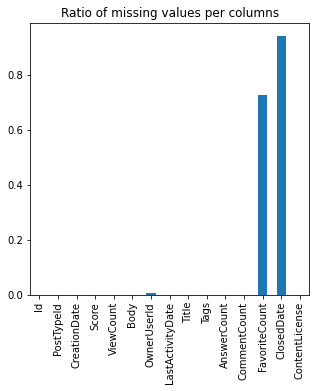

In [64]:
'''
5. Check of missing values to verify that only unnecessary columns showing any missing values 
'''
plt.figure(figsize=(5, 5))
questions_df_dtypes.isnull().mean(axis=0).plot.bar()
plt.title("Ratio of missing values per columns")

In [65]:
'''
6. Check for duplicate entries
'''
questions_df_dtypes.loc[questions_df_dtypes.duplicated(subset="Title", keep=False) == True]
#questions_df_dtypes.loc[questions_df_dtypes.duplicated(subset="Body", keep=False) == True]

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense
411,461,1,2014-06-18 22:10:58.497,12,1336,<p>There's this side project I'm working on wh...,986,2017-11-06 08:07:09.260,Preference Matching Algorithm,<bigdata><text-mining><recommender-system>,2,0,2,NaT,CC BY-SA 3.0
424,477,1,2014-06-18 22:15:43.820,2,561,<p>There's this side project I'm working on wh...,986,2014-06-19 10:30:43.993,Preference Matching Algorithm,<algorithms>,1,3,NaN,2014-06-26 05:31:41.193,CC BY-SA 3.0
1167,2313,1,2014-10-20 06:38:16.490,5,1156,"<p>Where is the difference between one-class, ...",4717,2015-03-03 14:21:51.033,Machine Learning - Where is the difference bet...,<machine-learning><data-mining><classification...,2,2,5,NaT,CC BY-SA 3.0
1170,2316,1,2014-10-19 21:03:35.390,1,47,"<p>Where is the difference between one-class, ...",4717,2014-10-20 10:38:59.437,Machine Learning - Where is the difference bet...,<machine-learning><classification><data-mining>,0,1,NaN,2014-10-21 14:09:06.617,CC BY-SA 3.0
8847,14941,1,2016-11-06 00:34:34.637,7,1245,<p>My understanding is that GPUs are more effi...,25891,2019-06-09 15:44:21.933,"After the training phase, is it better to run ...",<neural-network><deep-learning><gpu>,1,0,2,NaT,CC BY-SA 4.0
8862,14959,1,2016-11-06 01:19:29.090,3,435,<p>My understanding is that GPUs are more effi...,25891,2016-11-06 18:30:17.030,"After the training phase, is it better to run ...",<machine-learning>,1,0,NaN,2016-11-06 19:26:15.520,CC BY-SA 3.0
14685,24194,1,2017-10-30 14:29:18.697,2,89,<p>I have a question regarding annotating text...,21257,2017-10-30 15:26:02.207,"Text annotating process, quality vs quantity?",<machine-learning><classification><data-mining...,1,0,NaN,NaT,CC BY-SA 3.0
15795,25696,1,2017-10-30 13:03:14.823,0,31,<p>I have a question regarding annotating text...,21257,2017-12-15 04:11:45.477,"Text annotating process, quality vs quantity?",<machine-learning><nlp><classification><data-m...,1,0,NaN,2017-12-16 16:41:19.660,CC BY-SA 3.0
20665,31989,1,2018-05-22 14:21:55.400,4,609,<p>I've found two different approaches online ...,51845,2019-01-23 11:23:25.883,What's the difference between finding the aver...,<python><scikit-learn><clustering><k-means>,1,3,0,NaT,CC BY-SA 4.0
20856,32221,1,2018-05-22 12:33:28.123,0,140,<p>I've found two different approaches online ...,51845,2018-05-27 12:22:53.200,What's the difference between finding the aver...,<python><scikit-learn><k-means>,1,5,NaN,NaT,CC BY-SA 4.0


In [66]:
'''
6a. found 10 duplicate titles and 5 duplicate bodies but with different tags by same OwnerUserID; 
decided to remove duplicates with the lowest score; all of which are the second occurrence
dataframe length prior to removal is 24363
'''
questions_df_dedup = questions_df_dtypes.drop_duplicates(subset = 'Title', keep= 'first')
questions_df_dedup.info() #24353

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24353 entries, 0 to 51393
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                24353 non-null  int64         
 1   PostTypeId        24353 non-null  int64         
 2   CreationDate      24353 non-null  datetime64[ns]
 3   Score             24353 non-null  int64         
 4   ViewCount         24353 non-null  int64         
 5   Body              24353 non-null  object        
 6   OwnerUserId       24238 non-null  object        
 7   LastActivityDate  24353 non-null  datetime64[ns]
 8   Title             24353 non-null  object        
 9   Tags              24353 non-null  object        
 10  AnswerCount       24353 non-null  int64         
 11  CommentCount      24353 non-null  int64         
 12  FavoriteCount     6708 non-null   object        
 13  ClosedDate        1416 non-null   datetime64[ns]
 14  ContentLicense    2435

In [67]:
'''
6b. Verify removal of duplicates and correct lines removed
'''
#questions_df_dedup.loc[questions_df_dedup.duplicated(subset="Title", keep=False) == True]
questions_df_dedup.loc[questions_df_dedup['Id'] == 461]

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense
411,461,1,2014-06-18 22:10:58.497,12,1336,<p>There's this side project I'm working on wh...,986,2017-11-06 08:07:09.260,Preference Matching Algorithm,<bigdata><text-mining><recommender-system>,2,0,2,NaT,CC BY-SA 3.0


# Tasks 7 & 8
7. PreProcessing Tag Information
8. Get a list of all the Tags and Their Frequency Counts and save to a new dataframe

In [68]:
'''
7. Preprocess tags - remove <>
Convert to a list of strings
'''
questions_df_dedup['Tags_SpaceDelimited'] = questions_df_dedup['Tags'].replace(r'><', ' ', regex=True)
questions_df_dedup['Tags_SpaceDelimited'] = questions_df_dedup['Tags_SpaceDelimited'].replace(r'>', '', regex=True)
questions_df_dedup['Tags_SpaceDelimited'] = questions_df_dedup['Tags_SpaceDelimited'].replace(r'<', '', regex=True)

def separate_tags(tags):
    return tags.split(" ")

questions_df_dedup['Tags_Clean'] = questions_df_dedup['Tags_SpaceDelimited'].apply(lambda y: separate_tags(y))
questions_df_dedup.head()

#print(questions_df_dedup['Tags_Clean'].loc[questions_df_dedup['Id'] == 73409])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense,Tags_SpaceDelimited,Tags_Clean
0,5,1,2014-05-13 23:58:30.457,9,708,<p>I've always been interested in machine lear...,5,2014-05-14 00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,1,1,1,2014-05-14 14:40:25.950,CC BY-SA 3.0,machine-learning,[machine-learning]
1,7,1,2014-05-14 00:11:06.457,4,441,"<p>As a researcher and instructor, I'm looking...",36,2014-05-16 13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,3,4,1,2014-05-14 08:40:54.950,CC BY-SA 3.0,education open-source,"[education, open-source]"
4,14,1,2014-05-14 01:25:59.677,22,1717,<p>I am sure data science as will be discussed...,66,2014-06-20 17:36:05.023,Is Data Science the Same as Data Mining?,<data-mining><definitions>,4,1,6,NaT,CC BY-SA 3.0,data-mining definitions,"[data-mining, definitions]"
5,15,1,2014-05-14 01:41:23.110,2,643,<p>In which situations would one system be pre...,64,2014-05-14 01:41:23.110,What are the advantages and disadvantages of S...,<databases>,0,1,NaN,2014-05-14 07:41:49.437,CC BY-SA 3.0,databases,[databases]
6,16,1,2014-05-14 01:57:56.880,17,382,"<p>I use <a href=""http://www.csie.ntu.edu.tw/~...",63,2014-05-17 16:24:14.523,Use liblinear on big data for semantic analysis,<machine-learning><bigdata><libsvm>,2,0,NaN,NaT,CC BY-SA 3.0,machine-learning bigdata libsvm,"[machine-learning, bigdata, libsvm]"


In [69]:
'''
8. Get a list of all the Tags and Their Frequency Counts and save to a new dataframe
'''
all_tags = [item for sublist in questions_df_dedup['Tags_Clean'].values for item in sublist]
my_set = set(all_tags)
unique_tags = list(my_set)

import collections
tag_freq = collections.Counter(all_tags)

kk=[list(tag_freq.keys()),list(tag_freq.values())]

tag_freq_df = pd.DataFrame(np.array(kk).T, columns=['Tags','Tag_Freq'])
tag_freq_df['Tag_Freq'] = pd.to_numeric(tag_freq_df['Tag_Freq'])

# Using this code to make the output clear
print("There are a total of {} tags in this dataset. \n".format(len(all_tags)))

print("There are {} unique tags in this dataset. \n".format(len(unique_tags)))

print("Here is a list of the top 50 unique tags sorted by frequency: \n")
tag_freq_df.sort_values(by='Tag_Freq', ascending = False).head(50)

There are a total of 72443 tags in this dataset. 

There are 590 unique tags in this dataset. 

Here is a list of the top 50 unique tags sorted by frequency: 



,Tags,Tag_Freq
0,machine-learning,7766
35,python,4500
59,neural-network,3249
81,deep-learning,3162
56,classification,2112
220,keras,2010
65,scikit-learn,1491
217,tensorflow,1440
36,nlp,1354
21,r,1205


# Tasks 8 & 9 Exploratory Analysis
8. Exploratory anal/viz on tags related to their frequency
9. Show this another way; pie charts and word clouds

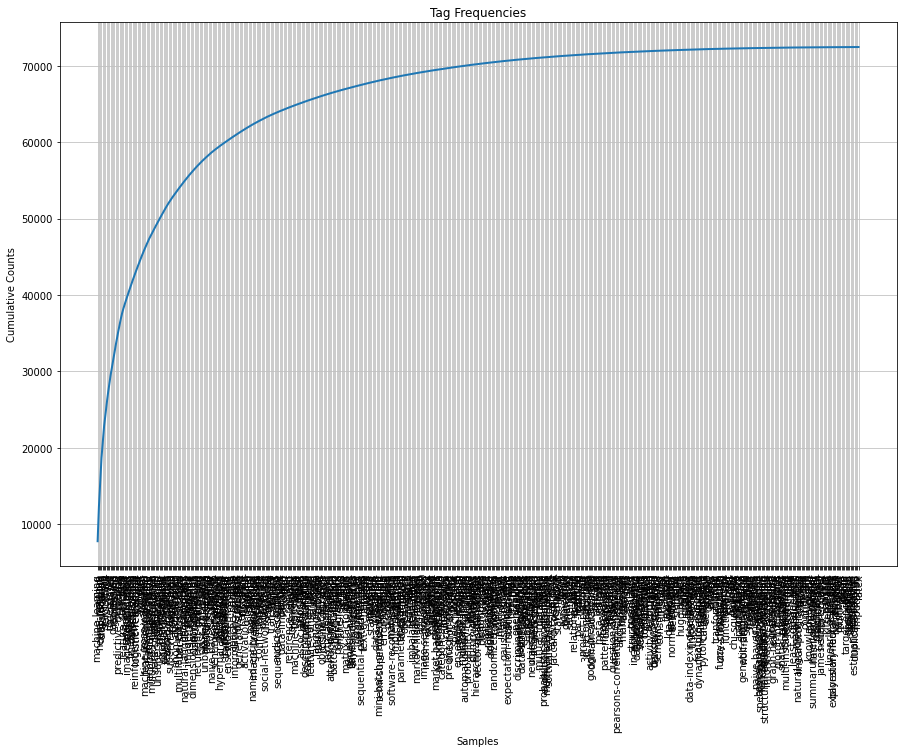

In [70]:
'''
9. Do some exploratory anal/viz on tags related to their frequency
Using nltk and matplotlib libraries
'''
tags = nltk.FreqDist(all_tags)

fig, ax = plt.subplots(figsize=(15, 10))
tags.plot(590, title= "Tag Frequencies", cumulative=True)

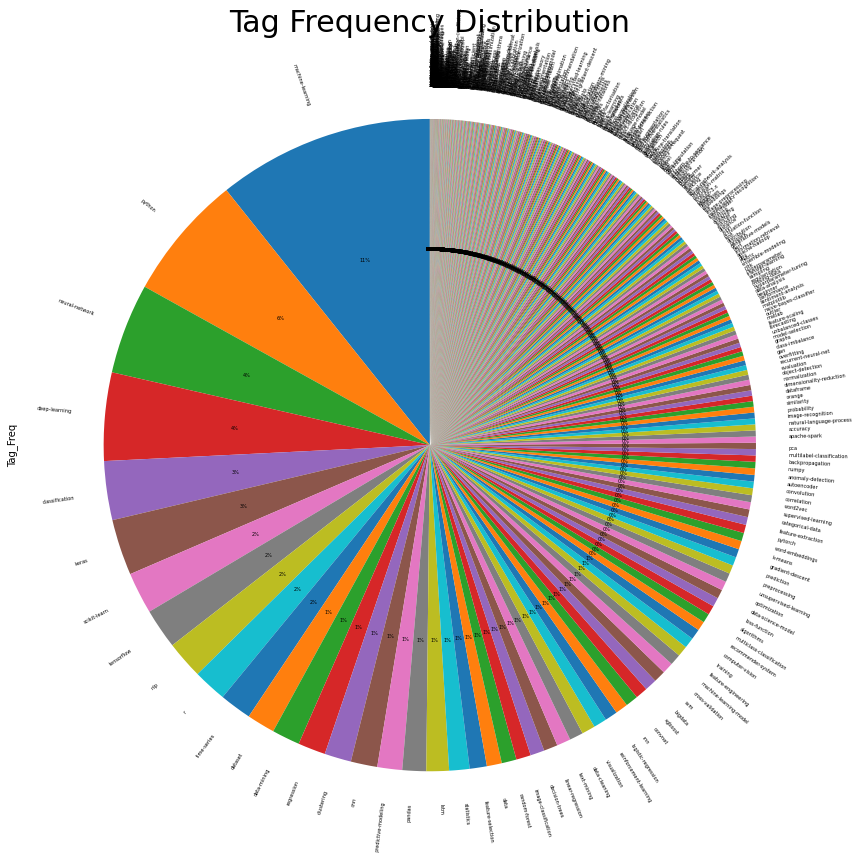

In [71]:
'''
9a. Show this another way; by using a pie chart you can see that the top 32 tags account for about 60% of the data
'''
tag_freq_srtd = tag_freq_df.sort_values(by='Tag_Freq', ascending = False)
tag_freq_srtd.set_index('Tags', inplace=True)

tag_freq_srtd.plot.pie(x='Tags',y='Tag_Freq', title='Tag Frequency Distribution', legend=False, autopct='%1.0f%%', startangle= 90, rotatelabels = True, figsize=(15,15), \
fontsize = 5).title.set_size(30)

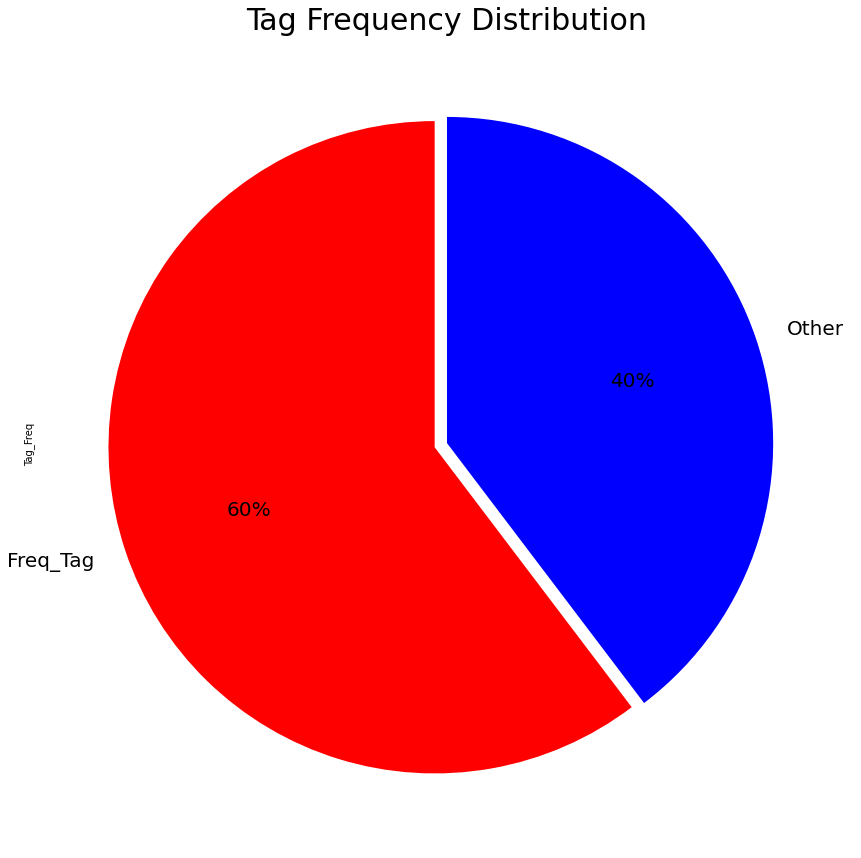

In [72]:
'''
9b. A better illustration to show this distribution 
'''
def top_tags(tag_freq):
  if tag_freq > 450:
    return 'Freq_Tag'
  else:
    return 'Other'

tag_freq_srtd['Tag_Desc'] = tag_freq_srtd['Tag_Freq'].apply(lambda x: top_tags(x))
tag_freq_srtd.head()

tag_freq_grouped = tag_freq_srtd.groupby(by='Tag_Desc').sum().head(2)
tag_freq_grouped.plot.pie(x='Tags_Desc',y='Tag_Freq', title='Tag Frequency Distribution', legend=False, autopct='%1.0f%%', startangle= 90, colors = ['r','b'], \
                          explode=(0.04,0), fontsize = 20, figsize=(15,15)).title.set_size(30)

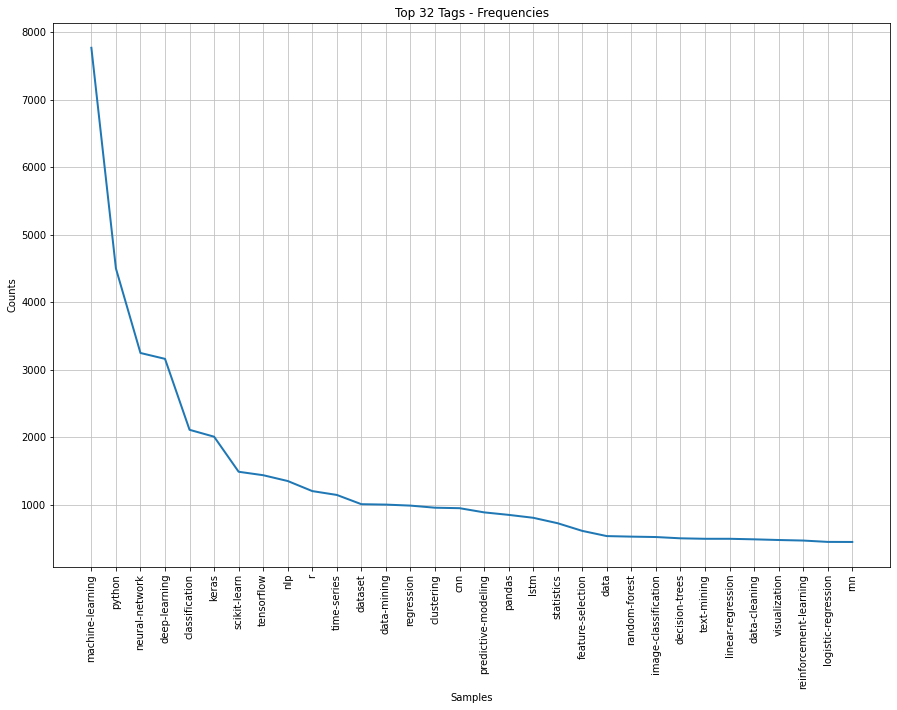

In [73]:
'''
9b. From freq dist above, decided to use top 32 tags for prediction which accounts for 60% of the data
Will change other tags to "OTHER" in a later step.
'''
fig, ax = plt.subplots(figsize=(15, 10))
tags.plot(32, title= "Top 32 Tags - Frequencies", cumulative=False)

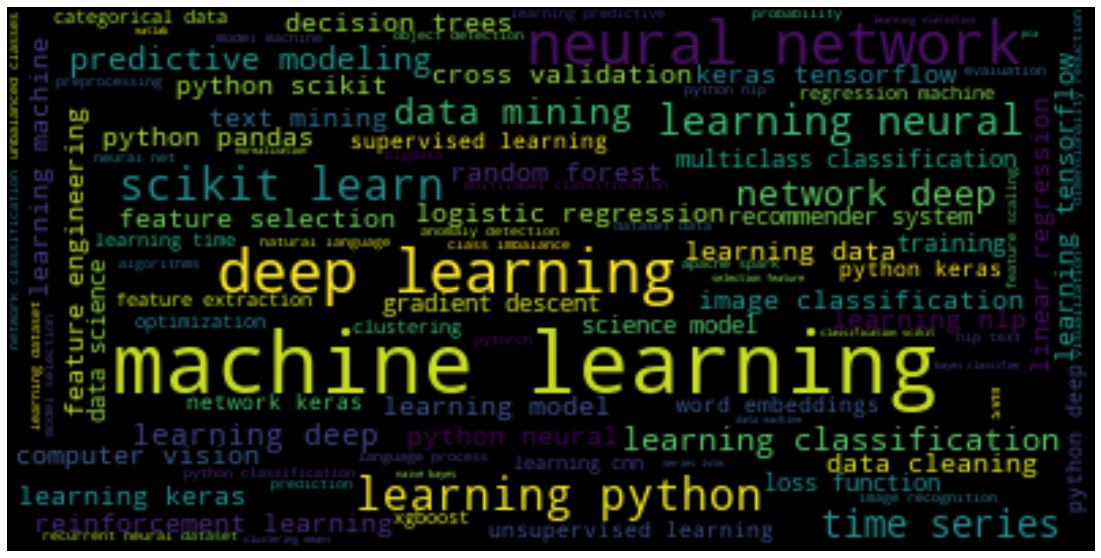

There are a total of 72443 tags.


In [74]:
'''
9c. Wordcloud of all tags; attempt one using the standard solution; despite not including any stopwords, the program is still not handling hyphens properly - 
I want to keep the hyphens!
Tried using the clean all_tags list I generated also, which works successfully but still no hyphens. There should be 72443 tags total and 590 unique ones.
Try working with frequency next.
'''
text = " ".join(tag for tag in questions_df_dedup['Tags'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=set()).generate(text)
#wordcloud = WordCloud(stopwords=set()).generate_from_text(' '.join(all_tags))

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print ("There are a total of {} tags.".format(len(all_tags)))

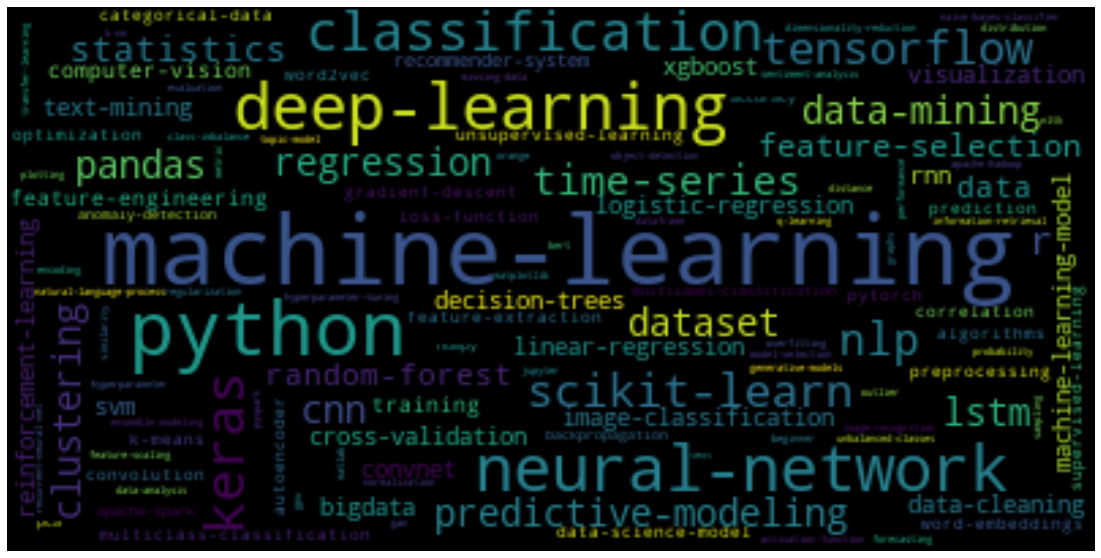

There are a total of 72443 tags.


In [75]:
'''
9d. Wordcloud of all tags using frequency; first must create a dictionary with frequency from the tags list; this method worked better than the other method above
as the hyphens are maintained!  Use this one in the report and presentation.
You can see that machine learning, deep learning, and neural networks and their associated software and libraries 
such as keras and tensorflow are the hottest topics.
'''
# Creating an empty dictionary  
freq = {} 
for item in all_tags: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1
   
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=set()).generate_from_frequencies(freq)

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print ("There are a total of {} tags.".format(len(all_tags)))

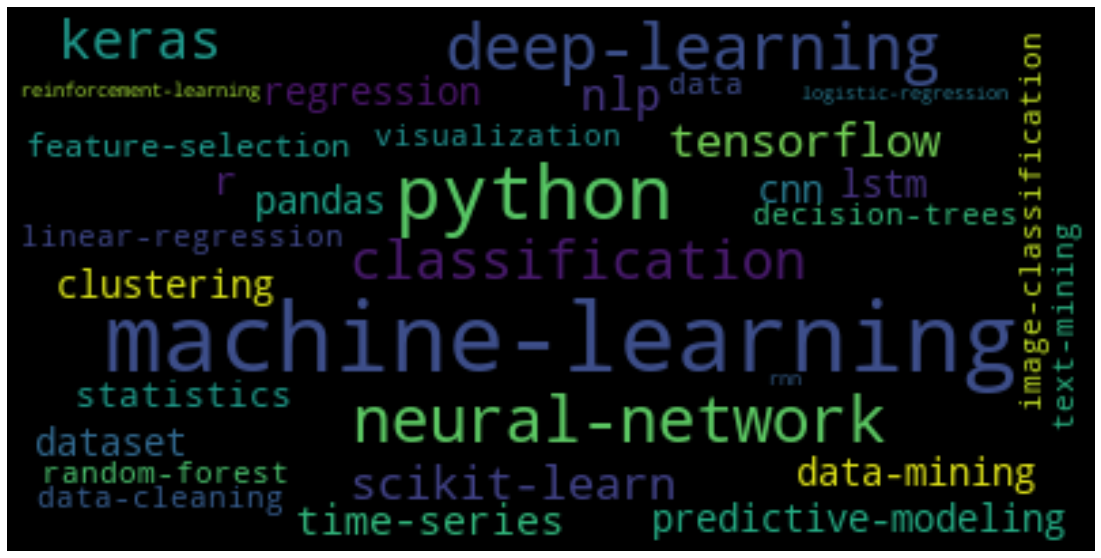

There are a total of 590 unique tags. We are showing only the top 32.


In [76]:
'''
9e. Wordcloud of Top 32 tags using frequency again
'''
text = " ".join(tag for tag in questions_df_dedup['Tags'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=set(),max_words=32).generate_from_frequencies((freq))

# Display the generated image:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print ("There are a total of {} unique tags. We are showing only the top 32.".format(len(unique_tags)))

# Task 10 Exploratory analysis on other features

In [77]:
'''
10. Do some exploratory anal/viz on other features
Get number of tags for each row
Summary Stats of Score, ViewCounts, and # of Tags per Question
'''

# Getting # of tags per questions:
questions_df_dedup['TagCount'] = questions_df_dedup['Tags_SpaceDelimited'].str.split(" ").str.len()
questions_df_dedup.head()

# Summary statistics of the these features
questions_df_dedup[['Score','ViewCount','TagCount']].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Score,ViewCount,TagCount
count,24353.000000,24353.000000,24353.000000
mean,2.005872,1387.329651,2.974705
std,5.433220,6895.850492,1.257866
min,-6.000000,2.000000,1.000000
25%,0.000000,36.000000,2.000000
50%,1.000000,114.000000,3.000000
75%,2.000000,578.000000,4.000000
max,214.000000,234355.000000,5.000000


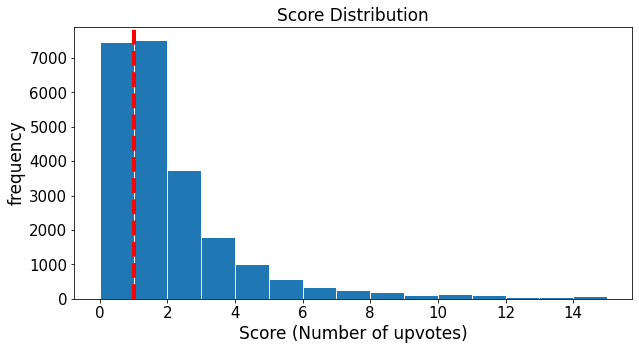

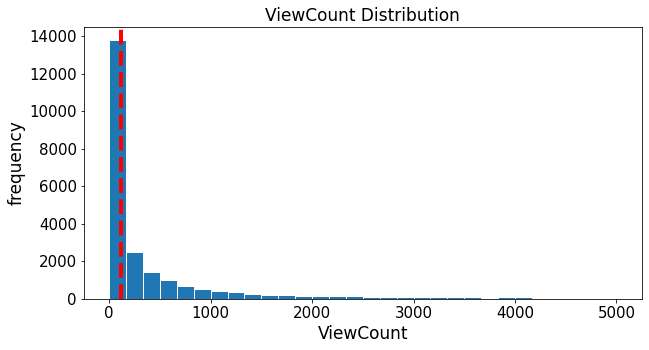

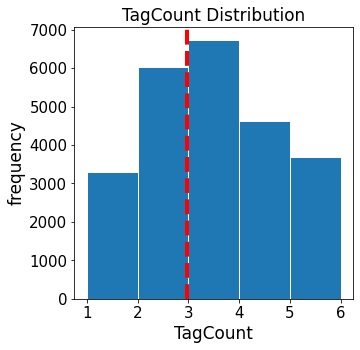

In [79]:
'''
10a. Visualizations of the distributions of these 3 features
Score and ViewCounts have skewed (poisson) distribution as would be expected from counts statistics
TagCount has a normal distribution
'''
questions_df_dedup['Score'].plot.hist(bins=15, figsize=(10,5), edgecolor='white',range=[0,15])
plt.axvline(questions_df_dedup['Score'].median(), color = 'r', linestyle = 'dashed', linewidth = 4)
plt.xlabel('Score (Number of upvotes)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Score Distribution', fontsize=17)
plt.show()

questions_df_dedup['ViewCount'].plot.hist(bins=30, figsize=(10,5), edgecolor='white',range=[0,5000])
plt.axvline(questions_df_dedup['ViewCount'].median(), color = 'r', linestyle = 'dashed', linewidth = 4)
plt.xlabel('ViewCount', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('ViewCount Distribution', fontsize=17)
plt.show()

questions_df_dedup['TagCount'].plot.hist(bins=5, figsize=(5,5), edgecolor='white',range=[1,6])
plt.axvline(questions_df_dedup['TagCount'].mean(), color = 'r', linestyle = 'dashed', linewidth = 4)
plt.xlabel('TagCount', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('TagCount Distribution', fontsize=17)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


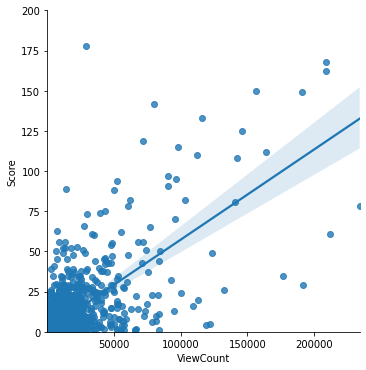

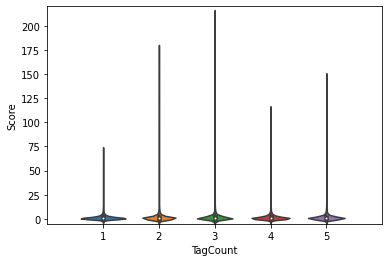

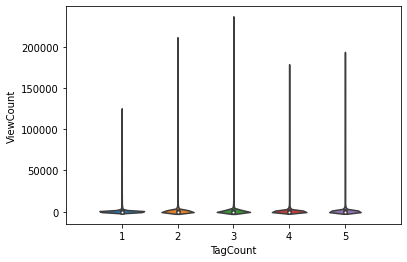

In [80]:
'''
10b. Explore the relationship between TagCounts, ViewCounts, and Score with both Scatter and Violin plots using seaborn library
Score tends to increase with ViewCounts, but neither of these have a relationship to TagCount; lots of positive outliers in Score
and ViewCounts
'''
# First convert TagCount to a category to display properly

questions_df_dedup['TagCount'] = questions_df_dedup['TagCount'].astype('category')
#questions_df_dedup.info()

# ViewCount vs Score

sns.lmplot(x = 'ViewCount', y = 'Score', data=questions_df_dedup)
plt.ylabel('Score')
plt.xlabel('ViewCount')
plt.ylim(0,200)
plt.show()

# TagCount vs Score

sns.violinplot(x = 'TagCount', y = 'Score', data=questions_df_dedup)
plt.ylabel('Score')
plt.xlabel('TagCount')
plt.ylim(-5,220)
plt.xlim(-1,5)
plt.show()

# ViewCount vs TagCount

sns.violinplot(x = 'TagCount', y = 'ViewCount', data=questions_df_dedup)
plt.ylabel('ViewCount')
plt.xlabel('TagCount')
plt.xlim(-1,5)
plt.show()

In [81]:
'''
10c. More exploratory visualizations showing highest score by view counts or by tag counts
Answering: "do the questions with tags in top 32 most frequent have a higher score on average than the rest?"
Begin by separating and renaming the tags to 'OTHER' that are not in top 32
'''
# First separate each tag into its own column; need to retype TagCount as integer

questions_df_dedup['TagCount'] = questions_df_dedup['TagCount'].astype('int')

# Creating first column
#print(questions_df_dedup['Tags_Clean'][:0])
questions_df_dedup['Tag1'] = questions_df_dedup['Tags_Clean'].map(lambda x: x[0])

# Process to create other columns Tag2-Tag5
mask1 = questions_df_dedup.loc[questions_df_dedup['TagCount'] > 1]
mask1['Tag2'] = mask1['Tags_Clean'].map(lambda x: x[1])
mask1 = mask1[['Id','Tag2']] 
mask2 = questions_df_dedup.loc[questions_df_dedup['TagCount'] > 2]
mask2['Tag3'] = mask2['Tags_Clean'].map(lambda x: x[2])
mask2 = mask2[['Id','Tag3']] 
mask3 = questions_df_dedup.loc[questions_df_dedup['TagCount'] > 3]
mask3['Tag4'] = mask3['Tags_Clean'].map(lambda x: x[3])
mask3 = mask3[['Id','Tag4']] 
mask4 = questions_df_dedup.loc[questions_df_dedup['TagCount'] > 4]
mask4['Tag5'] = mask4['Tags_Clean'].map(lambda x: x[4])
mask4 = mask4[['Id','Tag5']] 

questions_df_temp1 = questions_df_dedup.merge(mask1, how='left', on='Id')
questions_df_temp2 = questions_df_temp1.merge(mask2, how='left', on='Id')
questions_df_temp3 = questions_df_temp2.merge(mask3, how='left', on='Id')
questions_df_septags = questions_df_temp3.merge(mask4, how='left', on='Id')
questions_df_septags.tail()

# Build a list of the top 32 most frequent tags

tag_freq_srtd.reset_index(inplace = True)
frequent_tag_lst = tag_freq_srtd['Tags'].head(32).tolist()
print(frequent_tag_lst)

# Rename the tags in Tags1-Tags5 columns to 'Other' if not in the frequent_tag_lst

questions_df_septags['Tag1_Renamed'] = np.where(questions_df_septags['Tag1'].isin(frequent_tag_lst), questions_df_septags['Tag1'], 'Other')
questions_df_septags['Tag2_Renamed'] = np.where(questions_df_septags['Tag2'].isin(frequent_tag_lst), questions_df_septags['Tag2'], 'Other')
questions_df_septags['Tag3_Renamed'] = np.where(questions_df_septags['Tag3'].isin(frequent_tag_lst), questions_df_septags['Tag3'], 'Other')
questions_df_septags['Tag4_Renamed'] = np.where(questions_df_septags['Tag4'].isin(frequent_tag_lst), questions_df_septags['Tag4'], 'Other')
questions_df_septags['Tag5_Renamed'] = np.where(questions_df_septags['Tag5'].isin(frequent_tag_lst), questions_df_septags['Tag5'], 'Other')

# Account for nans

questions_df_septags.loc[(questions_df_septags['Tag2'].isna()), 'Tag2_Renamed'] = "NaN"
questions_df_septags.loc[(questions_df_septags['Tag3'].isna()), 'Tag3_Renamed'] = "NaN"
questions_df_septags.loc[(questions_df_septags['Tag4'].isna()), 'Tag4_Renamed'] = "NaN"
questions_df_septags.loc[(questions_df_septags['Tag5'].isna()), 'Tag5_Renamed'] = "NaN"

# QC results
#questions_df_septags.loc[questions_df_septags['Tag2'].isna()].head()
#questions_df_septags.head()
#questions_df_septags.loc[questions_df_septags['Tag2']=='c'].head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

['machine-learning', 'python', 'neural-network', 'deep-learning', 'classification', 'keras', 'scikit-learn', 'tensorflow', 'nlp', 'r', 'time-series', 'dataset', 'data-mining', 'regression', 'clustering', 'cnn', 'predictive-modeling', 'pandas', 'lstm', 'statistics', 'feature-selection', 'data', 'random-forest', 'image-classification', 'decision-trees', 'linear-regression', 'text-mining', 'data-cleaning', 'visualization', 'reinforcement-learning', 'logistic-regression', 'rnn']


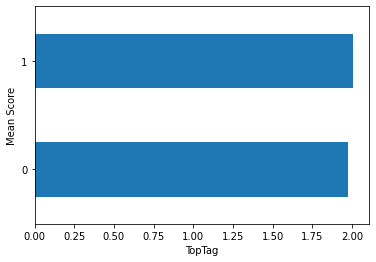

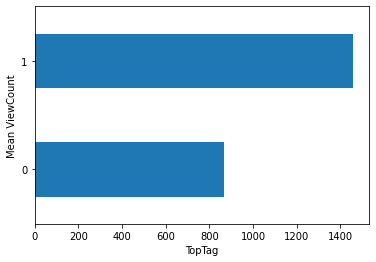

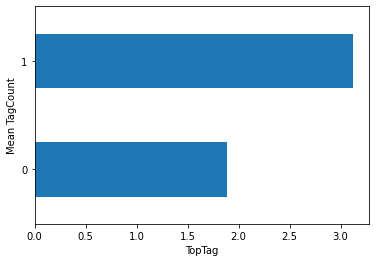

In [82]:
'''
10d. Now ready to answer the question posed above - do the questions with tags in top 32 most frequent have a higher score or View Count or Tag Count on average than the rest?
The answer can be determined by grouping by a TopTags flag and calculating the means of these features; results show that the mean difference of the Score between the questions with top 
tags and those without is not statistically significant; however the ViewCounts and TagCounts are statistically significant being almost twice the value where questions
are tagged with one or more of the top 32 most frequent tags; the latter 2 features should be ranked by order and included as features in the modelling portion
'''
# First make a new column with flag of 1 if one of the tags is in top 32 list

questions_df_septags['TopTag'] = np.where((questions_df_septags['Tag1_Renamed'].isin(frequent_tag_lst)) | (questions_df_septags['Tag2_Renamed'].isin(frequent_tag_lst)) \
                                          | (questions_df_septags['Tag3_Renamed'].isin(frequent_tag_lst)) | (questions_df_septags['Tag4_Renamed'].isin(frequent_tag_lst)) \
                                          | (questions_df_septags['Tag4_Renamed'].isin(frequent_tag_lst)), 1, 0)

#questions_df_septags.head()

# Second groupby the new TopTag column and plot results
questions_df_septags['TopTag'] = questions_df_septags['TopTag'].astype('category')
# questions_df_septags.info()
toptags_score = questions_df_septags.groupby("TopTag")["Score"].mean()
#toptags_score.head()
toptags_score.plot.barh()
plt.xlabel("TopTag")
plt.ylabel("Mean Score")
plt.show()

#optags_vcounts = questions_df_septags.groupby("TopTag")["ViewCount"].mean()
#toptags_vcounts.head()
toptags_vcounts.plot.barh()
plt.xlabel("TopTag")
plt.ylabel("Mean ViewCount")
plt.show()

#toptags_tcounts = questions_df_septags.groupby("TopTag")["TagCount"].mean()
#toptags_tcounts.head()
toptags_tcounts.plot.barh()
plt.xlabel("TopTag")
plt.ylabel("Mean TagCount")
plt.show()

In [83]:
'''
10e. Rank View Counts and Tag Counts
'''
questions_df_septags["VC_Rank"] = questions_df_septags['ViewCount'].rank(axis=0, method='first', ascending=False)

questions_df_septags["TC_Rank"] = questions_df_septags['TagCount'].rank(axis=0, method='first', ascending=False)

questions_df_septags.sort_values(by='TC_Rank', ascending=True).head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense,Tags_SpaceDelimited,Tags_Clean,TagCount,Tag1,Tag2,Tag3,Tag4,Tag5,Tag1_Renamed,Tag2_Renamed,Tag3_Renamed,Tag4_Renamed,Tag5_Renamed,TopTag,VC_Rank,TC_Rank
7,22,1,2014-05-14 05:58:21.927,149,191309,<p>My data set contains a number of numeric at...,97,2019-11-25 19:53:21.473,K-Means clustering for mixed numeric and categ...,<data-mining><clustering><octave><k-means><cat...,13,3,117,NaT,CC BY-SA 3.0,data-mining clustering octave k-means categori...,"[data-mining, clustering, octave, k-means, cat...",5,data-mining,clustering,octave,k-means,categorical-data,data-mining,clustering,Other,Other,Other,1,7.0,1.0
37,143,1,2014-05-18 14:37:20.477,10,825,"<p>As we all know, there are some data indexin...",229,2014-05-19 12:05:13.513,What is the most efficient data indexing techn...,<nosql><efficiency><indexing><data-indexing-te...,1,0,NaN,NaT,CC BY-SA 3.0,nosql efficiency indexing data-indexing-techni...,"[nosql, efficiency, indexing, data-indexing-te...",5,nosql,efficiency,indexing,data-indexing-techniques,.net,Other,Other,Other,Other,Other,0,4961.0,2.0
39,159,1,2014-05-18 19:46:44.653,6,528,<p>I see a lot of courses in Data Science emer...,199,2014-05-18 21:05:28.990,Is Data Science just a trend or is a long term...,<bigdata><machine-learning><databases><statist...,1,3,1,2014-05-19 08:54:23.303,CC BY-SA 3.0,bigdata machine-learning databases statistics ...,"[bigdata, machine-learning, databases, statist...",5,bigdata,machine-learning,databases,statistics,education,Other,machine-learning,Other,statistics,Other,1,6405.0,3.0
53,211,1,2014-05-27 10:41:33.220,9,4377,<p>I'm new to this community and hopefully my ...,295,2014-05-28 09:43:54.197,Human activity recognition using smartphone da...,<bigdata><machine-learning><databases><cluster...,2,0,2,NaT,CC BY-SA 3.0,bigdata machine-learning databases clustering ...,"[bigdata, machine-learning, databases, cluster...",5,bigdata,machine-learning,databases,clustering,data-mining,Other,machine-learning,Other,clustering,data-mining,1,1447.0,4.0
88,376,1,2014-06-15 00:00:51.657,8,128,"<p>I'm developing a distributed algorithm, and...",84,2014-07-18 04:50:58.287,How to compare experiments run over different ...,<bigdata><efficiency><performance><scalability...,3,0,1,NaT,CC BY-SA 3.0,bigdata efficiency performance scalability dis...,"[bigdata, efficiency, performance, scalability...",5,bigdata,efficiency,performance,scalability,distributed,Other,Other,Other,Other,Other,0,11634.0,5.0


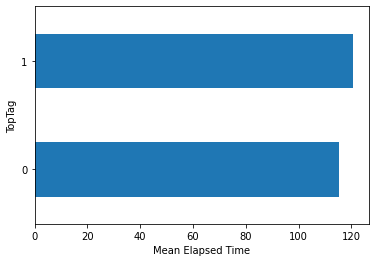

In [89]:
'''
10f. Should also look at importance of the time between creation date and last activity date 
difference in mean elapsed time is not statistically significant between questions with and without top tags
'''
from datetime import datetime, timedelta

def elapsed_time(c):
  return c["LastActivityDate"] - c["CreationDate"]

questions_df_septags['Elapsed_Time'] = questions_df_septags.apply(elapsed_time, axis = 1)
#questions_df_septags.head()

questions_df_septags['Elapsed_Time'].dt.days
questions_df_septags['Elapsed_Time_Int'] = pd.to_numeric(questions_df_septags['Elapsed_Time'].dt.days, downcast='integer')
#questions_df_septags.head()
#questions_df_septags.info()

questions_df_septags.groupby("TopTag")["Elapsed_Time_Int"].mean().plot.barh(y = "TopTag")
plt.ylabel("TopTag")
plt.xlabel("Mean Elapsed Time")
plt.show()

# Task 11 - Export out results

In [ ]:
'''
11a. We have filtered, cleaned the tags, gathered and ranked some important features.
Now write out for safekeeping
'''
pickle_out = open("/content/drive/My Drive/Capstone2/Data/questions_df_09252020.pickle","wb")
pickle.dump(questions_df_septags, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
pickle_out.close()

In [ ]:
'''
11b. Also writing out the tag frequency dataframe for future use.
'''
pickle_out = open("/content/drive/My Drive/Capstone2/Data/tag_freq_srtd_10072020.pickle","wb")
pickle.dump(tag_freq_srtd, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
pickle_out.close()